In [103]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import os
import SolarStormwatchIIAnalysis as ssw
import hi_processing.images as hip
import sunpy.map as smap
import astropy.units as u
import matplotlib as mpl
import tables
import glob
from sklearn.neighbors import KernelDensity
import skimage.measure as measure
import skimage.color as skcol
%matplotlib inline

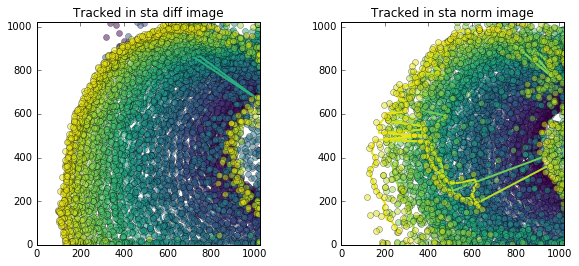

In [104]:
project_dirs = ssw.get_project_dirs()
ssw_out_name = os.path.join(project_dirs['out_data'], 'all_classifications_matched_ssw_events_plus_HPR.hdf5')

# Load in the event tree dictionary to easily iterate over the events/craft/img type
ssw_event_tree = ssw.get_event_subject_tree(active=True)

# get handle to the ssw out data
ssw_out = tables.open_file(ssw_out_name, mode="r")
# Loop over events, craft and image type
for event_k, event in ssw_event_tree.iteritems():
    for craft_k, craft in event.iteritems():
        # Make a plot for each image type.
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        for i, img_k in enumerate(craft.iterkeys()):

            # Get path to this node of the data, pull out the group of times
            path = "/".join(['', event_k, craft_k, img_k])
            times = ssw_out.get_node(path)
            # Set up the normalisation and colormap for the plots
            norm = mpl.colors.Normalize(vmin=0, vmax=len(times._v_groups))
            cmap = mpl.cm.viridis
            for frame_count, t in enumerate(times):

                all_coords = pd.DataFrame.from_records(t.coords.read())
                cme_coords = pd.DataFrame.from_records(t.cme_coords.read())
                cme_coords.replace(to_replace=[99999], value=np.NaN, inplace=True)
                
                ax[i].plot(cme_coords['x'], cme_coords['y'], '-', color=cmap(norm(frame_count)), linewidth=2)
                ax[i].plot(all_coords['x'], all_coords['y'], 'o', color=cmap(norm(frame_count)), alpha=0.5)
                
                # Label it up and format
                ax[i].set_title("Tracked in {0} {1} image".format(craft_k, img_k))
                ax[i].set_xlim(0, 1023)
                ax[i].set_ylim(0, 1023)
                ax[i].set_aspect('equal')
            
        break
    break

In [116]:
def get_fwhm(x, pdf):
    """
    Function to calculate the full width at half maximum of a 1-d distribution.
    :param x:
    :param pdf:
    :return:
    """

    #Calc FWHM
    pdf_max = pdf.max()
    pdf_hm = pdf_max/2.0
    id_max = np.argwhere(pdf==pdf_max).ravel()
    if len(id_max)>1:
        id_max = id_max[0]
    x_max = x[id_max]

    # Look low.
    pdf_l = pdf[x<x_max]
    x_l = x[x<x_max]
    if len(x_l)>1:
        x_hm_l = x_l[np.argmin(np.abs(pdf_l - pdf_hm))]
    else:
        x_hm_l = np.NaN

    # Look high.
    pdf_h = pdf[x>x_max]
    x_h = x[x>x_max]
    if len(x_h)>1:
        x_hm_h = x_h[np.argmin(np.abs(pdf_h - pdf_hm))]
    else:
        x_hm_h = np.NaN

    return x_hm_l, x_max, x_hm_h



def kernel_estimate_cme_front(coords, hi_map, kernel="epanechnikov", bandwidth=40, thresh=10):
    """
    A function that uses Kernel density estimation and skeletonization to estimate the CME front location from the
    cloud of classifications for this asset.
    :param coords: Dataframe of classification coordinates, with columns 'x', and 'y' for the x pixels and y pixels, and 'el
                   and 'pa' for the HPR coordinates.    
    :param hi_map: A sunpy map of the HI image current being analysed.
    :param kernel: String name of any valid kernal in scikit-learn.neighbours.KernalDensity.
    :param bandwidth: Float value of the bandwidth to be used by the kernal. Defaults to 40 pixels, as this is
                      approximately the error in classifications if made using a touchscreen.
    :param thresh: Float value of threshold to apply to the density map to identify the CME skeleton. Defaults to 10,
                   but this is only from playing around and hasn't been thoroughly testted.
    :return: coords: A dataframe with columns:
                     x: x-pixel coords of the best estimate of the cme front
                     y: y-pixel coords of the best estimate of the cme front
                     pa:
                     el:
                     el_lo:
                     el_hi:
    """
    if coords.shape[0] < 20:
        print("Error: <20 coordinates provided, CME front identification likely to be poor")

    if kernel not in {"gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"}:
        print("Error: invalid kernel, defaulting to epanechnikov")
        kernel = "epanechnikov"

    if not isinstance(bandwidth, (int, float)):
        print("Error: bandwidth should be an int or float number. defaulting to 40")
        bandwidth = 40

    if not isinstance(thresh, (int, float)):
        print("Error: thresh should be an int or float number. defaulting to 10")
        bandwidth = 10

    # Get all pixel coordinates in the image frame.
    x = np.arange(0, 1024)
    y = np.arange(0, 1024)
    xm, ym = np.meshgrid(x, y)
    # Get all coords for KSdensity
    all_coords = np.vstack([xm.ravel(), ym.ravel()]).T
    # Lookup HPR coords in frame
    elm, pam = hip.convert_pix_to_hpr(xm*u.pix, ym*u.pix, hi_map)
    # Loose the units as not needed
    elm = elm.value
    pam = pam.value

    # Parse classification cloud to kernel density estimator. Returns log of density.
    xy = np.vstack([coords['x'].values.ravel(), coords['y'].values.ravel()]).T
    
    # Get flags for aborting the CME fit distributions
    fit_distribution = True
    fit_cme_distribution = True

    if xy.shape[0] == 0:
        fit_distribution = False

    if fit_distribution:
        # Use first stab at kernel density to
        kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(xy)
        log_pdf = np.reshape(kde.score_samples(all_coords), xm.shape)
        # Convert the pdf to a binary map of where the distribution is > np.max(dist)/thresh
        pdf = np.exp(log_pdf.copy())
        thresh = np.max(pdf) / thresh
        pdf_binary = pdf.copy()
        pdf_binary[pdf_binary < thresh] = 0
        pdf_binary[pdf_binary >= thresh] = 1
        # Only keep the largest CME feature in the binary map.
        # Label each binary blob
        pdf_binary_label = measure.label(pdf_binary.astype(int))
        # Make sure background points have the same zero label.
        pdf_binary_label[pdf_binary == 0] = 0
        
        #fig,ax = plt.subplots(1,4,figsize=(15,5))
        #ax[0].imshow(pdf, cmap='gray')
        #ax[1].imshow(pdf_binary, cmap='gray')
        #ax[2].imshow(pdf_binary_label, cmap='gray')        
        #overlay = skcol.label2rgb(pdf_binary_label, colors=['black','red','blue','blue','blue','blue','blue','blue','blue','blue','yellow','yellow','yellow','yellow'])
        #ax[3].imshow(overlay)
        
        # Find how many unique labels and how many pixels in each label
        lab, cnt = np.unique(pdf_binary_label, return_counts=True)
        
        # Sort these so largest is last in list.
        # Largest should always be the background. So keep two largest - background and clearest CME identification
        lab = lab[np.argsort(cnt)]
        for l in lab[:-2]:
            pdf_binary_label[pdf_binary_label == l] = 0

        # Set the largest blob back to 1 rather than it's label.
        pdf_binary_label[pdf_binary_label != 0] = 1
        # Get the edge of this CME blob
        edge_coords = np.fliplr(measure.find_contours(pdf_binary_label,0)[0])
        #ax[3].plot(edge_coords[:,0],edge_coords[:,1],'y.')
        
        # Find classifications inside this polygon
        id_keep = []
        for idr, row in coords.iterrows():
            good_row = True
            if (row['y'] < 0) | (row['y'] > 1023):
                print "row: {0}, y : {1}".format(idr, row['y'])
                good_row = False
            if (row['x'] < 0) | (row['x'] > 1023):
                print "row: {0}, x : {1}".format(idr, row['x'])
                good_row = False
                
            if good_row:
                if pdf_binary_label[int(row['y']),int(row['x'])] == 1:
                    id_keep.append(True)
                else:
                    id_keep.append(False)
            else:
                id_keep.append(False)

        xy_in_cme = np.vstack([coords['x'][id_keep].values.ravel(), coords['y'][id_keep].values.ravel()]).T
        hpr_in_cme = np.vstack([coords['pa'][id_keep].values.ravel(), coords['el'][id_keep].values.ravel()]).T
        
        #overlay = skcol.label2rgb(pdf_binary_label, colors=['black','red','blue','blue','blue','blue','blue','blue','blue','blue','yellow','yellow','yellow','yellow',])
        #fig,ax = plt.subplots(1,4,figsize=(15,5))
        #ax[0].imshow(pdf, cmap='gray')
        #ax[1].imshow(pdf_binary, cmap='gray')
        #ax[2].imshow(overlay)
        #ax[3].plot(xy[:,0],xy[:,1],'k.')
        #ax[3].plot(xy_in_cme[:,0],xy_in_cme[:,1],'r.')
        #ax[3].set_aspect('equal')
        #for a in ax:
        #    a.set_xlim(0,1023)
        #    a.set_ylim(0,1023)
        
        # Now fit only these points
        # Are there any points left?
        if xy_in_cme.shape[0] == 0:
            fit_cme_distribution = False

        if fit_cme_distribution:
            kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(xy_in_cme)
            log_pdf = np.reshape(kde.score_samples(all_coords), xm.shape)
            cme_pdf = np.exp(log_pdf.copy())

            # Use classifications to find range of PA values to look up CME elongation for. Preallocate space for CME front
            pa_vals = np.arange(np.round(hpr_in_cme[:,0].min()), np.round(hpr_in_cme[:,0].max()), 1)
            cme_el_peak = np.zeros(pa_vals.shape)
            cme_el_lo = np.zeros(pa_vals.shape)
            cme_el_hi = np.zeros(pa_vals.shape)
            # Loop over position angles, get FWHM of the kernel density estimate along constant PA. Use as elon error est.
            for i, pa in enumerate(pa_vals):
                # Get pixel coords of this PA slice
                pa_slice = measure.find_contours(pam,pa)[0]
                # Get values rounded to nearest pixel
                pa_slice = pa_slice.astype(int)
                pdf_pa = cme_pdf[pa_slice[:, 0], pa_slice[:, 1]]
                el_pa = elm[pa_slice[:, 0], pa_slice[:, 1]]
                cme_el_lo[i], cme_el_peak[i], cme_el_hi[i] = get_fwhm(el_pa, pdf_pa)

            if len(cme_el_peak) != 0:
                x, y = hip.convert_hpr_to_pix(cme_el_peak * u.deg, pa_vals * u.deg, hi_map)
                x_lo, y_lo = hip.convert_hpr_to_pix(cme_el_lo * u.deg, pa_vals * u.deg, hi_map)
                x_hi, y_hi = hip.convert_hpr_to_pix(cme_el_hi * u.deg, pa_vals * u.deg, hi_map)
                # Setup output dataframe
                cme_coords = pd.DataFrame({'x': x.value, 'y': y.value,
                                           'x_lo': x_lo.value, 'y_lo': y_lo.value,
                                           'x_hi': x_hi.value, 'y_hi': y_hi.value,
                                           'pa': pa_vals, 'el': cme_el_peak,
                                           'el_lo': cme_el_lo, 'el_hi': cme_el_hi})

                # Check any NaNs are set to bad val
                cme_coords[cme_coords.isnull()] = 99999
            else:
                fit_cme_distribution = False

    # Handle bad values case
    if (not fit_distribution) or (not fit_cme_distribution):
        # Set bad values to 99999, as pytables can't handle NaN
        bad_val = 99999
        keys = ['x', 'y', 'x_lo', 'y_lo', 'x_hi', 'y_hi', 'pa', 'el', 'el_lo', 'el_hi']
        bad_val_dict = {k:bad_val for k in keys}
        cme_coords = pd.DataFrame(bad_val_dict, index=[0])

    return cme_coords

def make_animation(src, dst, tidy=True):
    cmd = " ".join(["convert -delay 20 -loop 0 ", src, dst])
    os.system(cmd)
    if tidy:
        files = glob.glob(src)
        for f in files:
            os.remove(f)

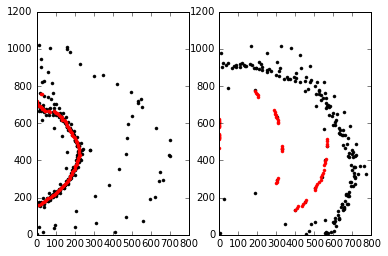

In [106]:
project_dirs = ssw.get_project_dirs()
ssw_out_name = os.path.join(project_dirs['out_data'], 'all_classifications_matched_ssw_events_plus_HPR.hdf5')

# Load in the event tree dictionary to easily iterate over the events/craft/img type
ssw_event_tree = ssw.get_event_subject_tree(active=True)

# get handle to the ssw out data
ssw_out = tables.open_file(ssw_out_name, mode="r")
event_k = 'ssw_009'
craft_k = 'stb'
img_k = 'diff'

# Get path to this node of the data, pull out the group of times
path = "/".join(['', event_k, craft_k, img_k])
times = ssw_out.get_node(path)

fig, ax = plt.subplots(1,2)
cme1a = pd.DataFrame.from_records(times.T20121005_124901.cme_coords.read())
annos1a = pd.DataFrame.from_records(times.T20121005_124901.coords.read())
ax[0].plot(annos1a['x'],annos1a['y'],'k.')
ax[0].plot(cme1a['x'],cme1a['y'],'r.')

cme2a = pd.DataFrame.from_records(times.T20121006_020901.cme_coords.read())
annos2a = pd.DataFrame.from_records(times.T20121006_020901.coords.read())
ax[1].plot(annos2a['x'],annos2a['y'],'k.')
ax[1].plot(cme2a['x'],cme2a['y'],'r.')

In [117]:
# Get HI map for this 
fig_dir = r'C:\Users\Luke\PycharmProjects\SolarStormwatchIIAnalysis\figures\cme_front_test'

events = ['ssw_007','ssw_008','ssw_009','ssw_012']
craft = ['sta','stb']
img_k = 'diff'

for event_k in events:
    for craft_k in craft:
        # Get path to this node of the data, pull out the group of times
        path = "/".join(['', event_k, craft_k, img_k])
        times = ssw_out.get_node(path)

        for t in times:
            t_start = pd.to_datetime(t._v_title)
            annos = pd.DataFrame.from_records(t.coords.read())
            cme_old = pd.DataFrame.from_records(t.cme_coords.read())
            files = hip.find_hi_files(t_start, t_start, craft=craft_k, camera='hi1', background_type=1)
            hi_map = smap.Map(files[0])
            # Now use kernal density estimation to identify pixel coordinates of the CME front.
            cme_new = kernel_estimate_cme_front(annos, hi_map, kernel="epanechnikov", bandwidth=40, thresh=10)

            fig, ax = plt.subplots(1,2, figsize=(13,6))
            ax[0].plot(annos['x'],annos['y'],'k.')
            ax[0].plot(cme_old['x'],cme_old['y'],'r.')

            ax[1].plot(annos['x'],annos['y'],'k.')
            ax[1].plot(cme_new['x'],cme_new['y'],'r.')
            for a in ax:
                a.set_xlim(-20,1040)
                a.set_ylim(-20,1040)
                a.set_aspect('equal')    
        
            plt.subplots_adjust(left=0.05,bottom=0.05,right=0.95,top=0.95,wspace=0.05)
    
            fig_name = "_".join([event_k,craft_k,img_k,t_start.strftime('%Y%m%d_%H%M%S')]) + '.jpg'
            out_name = os.path.join(fig_dir,fig_name)
            plt.savefig(out_name)
            plt.close('all')

        src = os.path.join(fig_dir, '*.jpg')
        gif_name = "_".join([event_k, craft_k, img_k]) + '.gif'
        dst = os.path.join(fig_dir, gif_name)
        make_animation(src, dst, tidy=True)

row: 141, y : -40.0
row: 136, x : 1045.0
row: 62, x : 1026.0
row: 100, x : 1024.0
row: 275, x : 1025.0
row: 315, x : 1026.0
row: 356, x : 1034.0
row: 259, x : 1026.0
row: 163, x : 1025.0
row: 341, y : 1051.0
row: 341, x : 1041.0
row: 342, y : -29.0
row: 73, y : 1025.0
row: 51, y : -1.0
row: 39, y : 1130.0
row: 40, y : 1115.0
row: 41, y : -22.0
row: 44, y : 1091.0
row: 44, x : 1079.0
row: 45, y : -50.0
row: 30, x : 1064.0
row: 242, x : -4.0
row: 320, x : -33.0
row: 454, x : -2.0
row: 76, y : -1.0
row: 257, y : 1029.0
row: 162, y : 1028.0
row: 235, x : 1024.0
row: 129, x : 1025.0
row: 137, x : 1027.0
row: 142, x : 1031.0
row: 30, x : 1025.0
row: 54, x : 1025.0
row: 123, y : 1033.0
row: 136, x : 1027.0
row: 45, x : -2.0
row: 146, y : -15.0
row: 146, x : 1062.0
row: 310, x : 1025.0
row: 130, x : 1025.0
row: 227, y : 1026.0
row: 318, x : 1034.0
row: 87, x : -58.0
row: 68, x : 1025.0
row: 85, x : 1026.0
row: 110, x : 1024.0
row: 111, x : 1028.0
row: 79, x : 1025.0
row: 29, y : 1025.0
row: 29